# Table of contents
1. [Introduction](#introduction)
2. [Invoice sample](#invoice-sample)
3. [gemini](#gemini)
4. [extract-json](#extract-json)
5. [Using all files](#using-all-files)
6. [Saving the output](#saving-the-output)
7. [Conclusion](#conclusion)

## Introduction
This notebook demonstrates how to extract details from a PDF invoice using the `gemini` and `save-as-json` nodes.

## Invoice sample
The sample invoice used in this notebook is a PDF file that contains the following details:

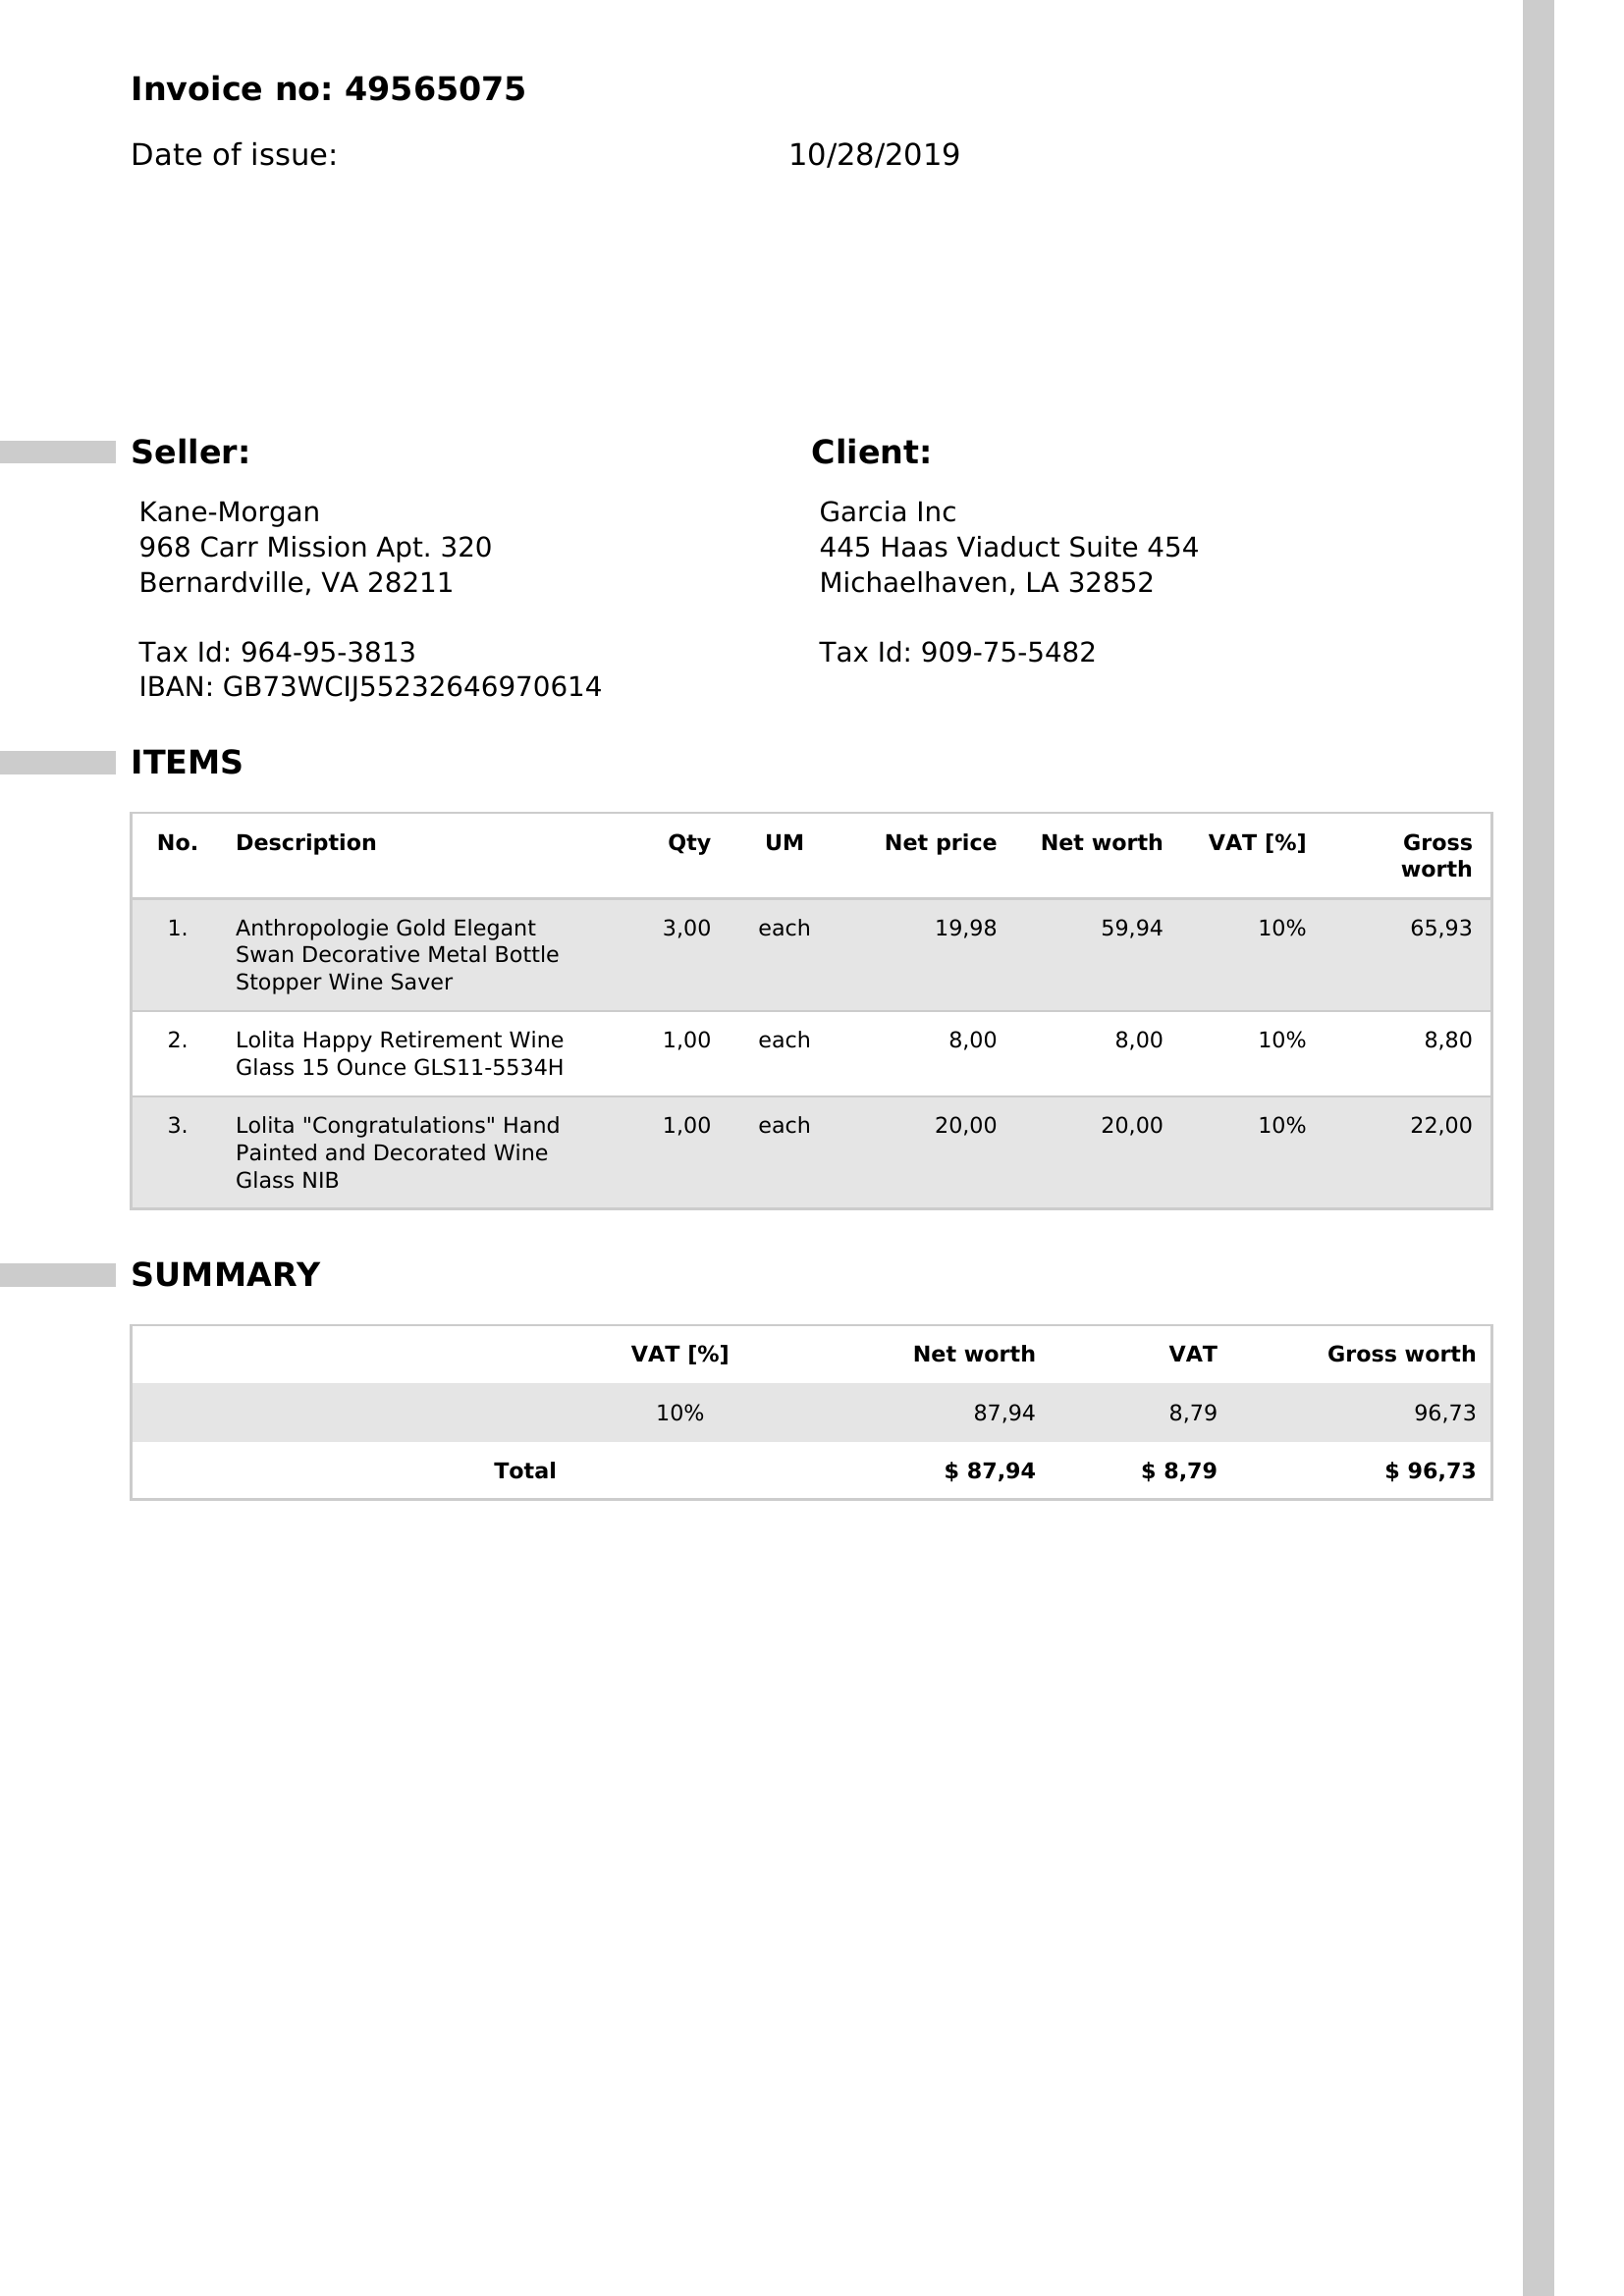

In [1]:
from pdf2image import convert_from_path  # pdf not getting displayed in jupyter notebook so using pdf2image to convert pdf to image
from IPython.display import display, HTML
from pathlib import Path

# Project root directory
project_root = Path().resolve()

# Path to your PDF file
pdf_path = project_root / 'invoices' / 'invoice_10.pdf'

# Convert pdf to an image
images = convert_from_path(pdf_path)
display(images[0])

## gemini
The `gemini` model is used to extract the text from the PDF invoice.

In [2]:
import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv()

GCP_KEY = os.getenv("GCP_KEY")

genai.configure(api_key=GCP_KEY)
model = genai.GenerativeModel("gemini-1.5-flash")

## extract-json
The `extract-json` script is used to extract the required details from the file and return as json.

In [4]:
import base64
import json
import re
from json2html import json2html

# encode and decode the pdf file using base64 to make sure the file is in the correct format
with open(pdf_path, "rb") as pdf_file:
    pdf_data = pdf_file.read()
transformed_pdf = base64.standard_b64encode(pdf_data).decode("utf-8")

# Prompt for the model
prompt = "Extract invoice details from the file . and write as json"

# Generate content from the model
response = model.generate_content(
    [{'mime_type': 'application/pdf', 'data': transformed_pdf},
    prompt]
)
response_text = response.text

# Extract JSON data from model response
match = re.search(r"\{.*\}", response_text, re.DOTALL)
if match:
    invoice_data = json.loads(match.group(0))
else:
    raise ValueError("No valid JSON found in response")

# Print extracted JSON as HTML table
html_table = json2html.convert(json=invoice_data)
display(HTML(html_table))

## Using all files
The `gemini` and `extract-json` nodes are now used to extract the details from all the PDF invoice.

In [8]:
from tqdm.auto import tqdm 

class Invoice:
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, key):
        return self.data[key]
    
class InvoiceExtractor:

    def __init__(self, model):
        self.model = model

    @staticmethod
    def transform_pdf(file_path):
        with open(file_path, "rb") as pdf_file:
            pdf_data = pdf_file.read()
        return base64.standard_b64encode(pdf_data).decode("utf-8")
    
    @staticmethod
    def extract_json(response_text):
        """Extracts JSON data from model response."""
        match = re.search(r"\{.*\}", response_text, re.DOTALL)
        if match:
            return json.loads(match.group(0))
        raise ValueError("No valid JSON found in response")

    def extract(self, pdf_path):
        encoded_pdf = self.transform_pdf(pdf_path)
        prompt = "Extract invoice details from the file . and write as json"

        response = self.model.generate_content(
            [{'mime_type': 'application/pdf', 'data': encoded_pdf},
            prompt]
        )

        response_text = response.text
        json_start = response_text.find("{")
        json_end = response_text.rfind("}") + 1
        json_str = response_text[json_start:json_end]
        invoice_data = json.loads(json_str)

        return Invoice(invoice_data)
    def extract_all(self, pdf_dir, limit=None):
        invoices = []
        pdfs = list(pdf_dir.glob("*.pdf"))
        len_pdfs = len(pdfs)
        if limit:
            if limit > len_pdfs:
                limit = len_pdfs
            pdfs = pdfs[:limit]      
              
        for pdf_path in tqdm(pdfs):
            invoice = self.extract(pdf_path)
            invoices.append(invoice)
        return invoices
    
    def display(self, invoice):
        html_table = json2html.convert(json=invoice.data)
        display(HTML(html_table))

    def display_all(self, invoices):
        for invoice in invoices:
            self.display(invoice)

    def save(self, invoice, output_dir):
        output_dir.mkdir(parents=True, exist_ok=True)
        output_path = output_dir / f"{invoice['invoice_no']}.json"
        with open(output_path, "w") as output_file:
            json.dump(invoice.data, output_file, indent=2)

    def save_all(self, invoices, output_dir):
        for invoice in invoices:
            self.save(invoice, output_dir)
    
extractor = InvoiceExtractor(model)
invoices = extractor.extract_all(project_root / 'invoices', limit=2)
extractor.display_all(invoices)
extractor.save_all(invoices, project_root / 'output_invoices')

  0%|          | 0/2 [00:00<?, ?it/s]